In [1]:
import os
import typing as tp
import math

import pickle
import numpy as np
import ffmpeg
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchaudio

from hear21passt.base import get_basic_model, get_model_passt

In [2]:
class PaSSTMTG(nn.Module):
    def __init__(self, n_classes=183):
        super(PaSSTMTG, self).__init__()

        self.passt = get_basic_model(mode="logits")
        self.passt.net =  get_model_passt(arch="passt_s_swa_p16_128_ap476", n_classes=n_classes)

    def forward(self, x):
        passt_logit = self.passt(x)
        logit = nn.Sigmoid()(passt_logit)

        return logit

def get_passt():
    passt = PaSSTMTG()
    state_dict = torch.load('/home/felipe/Documents/Github/Pt-Brdo/src/pt_brdo/passt/passt_epoch_1_acc_0.975.pth')
    passt.load_state_dict(state_dict)
    return passt

In [3]:
model = PaSSTMTG()

S = torch.load('/home/felipe/Documents/Github/Pt-Brdo/src/pt_brdo/passt/passt_epoch_1_acc_0.975.pth')
model.load_state_dict(S)

# inference
model.eval()
model = model.cuda()



 Loading PASST TRAINED ON AUDISET 


PaSST(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), ep

In [4]:
def get_tag_list(option):
    if option == 'top50tags':
        tag_list = np.load('tag_list_50.npy')
    else:
        tag_list = np.load('tag_list.npy')
        if option == 'genre':
            tag_list = tag_list[:87]
        elif option == 'instrument':
            tag_list = tag_list[87:127]
        elif option == 'moodtheme':
            tag_list = tag_list[127:]
    return list(tag_list)

tags = get_tag_list('all')

for idx, tag in enumerate(tags):
    tags[idx] = tag.split('---')[-1]

tags

['60s',
 '70s',
 '80s',
 '90s',
 'acidjazz',
 'alternative',
 'alternativerock',
 'ambient',
 'atmospheric',
 'blues',
 'bluesrock',
 'bossanova',
 'breakbeat',
 'celtic',
 'chanson',
 'chillout',
 'choir',
 'classical',
 'classicrock',
 'club',
 'contemporary',
 'country',
 'dance',
 'darkambient',
 'darkwave',
 'deephouse',
 'disco',
 'downtempo',
 'drumnbass',
 'dub',
 'dubstep',
 'easylistening',
 'edm',
 'electronic',
 'electronica',
 'electropop',
 'ethno',
 'eurodance',
 'experimental',
 'folk',
 'funk',
 'fusion',
 'groove',
 'grunge',
 'hard',
 'hardrock',
 'hiphop',
 'house',
 'idm',
 'improvisation',
 'indie',
 'industrial',
 'instrumentalpop',
 'instrumentalrock',
 'jazz',
 'jazzfusion',
 'latin',
 'lounge',
 'medieval',
 'metal',
 'minimal',
 'newage',
 'newwave',
 'orchestral',
 'pop',
 'popfolk',
 'poprock',
 'postrock',
 'progressive',
 'psychedelic',
 'punkrock',
 'rap',
 'reggae',
 'rnb',
 'rock',
 'rocknroll',
 'singersongwriter',
 'soul',
 'soundtrack',
 'swing',
 '

In [5]:
def plot_model_out(model_out:torch.Tensor, song:str):
    model_out = (model_out * 100)
    max_value = math.ceil(model_out.max().item())
    model_out = model_out.cpu().detach().numpy()[0]

    # set width of bar
    barWidth = 0.4
    fig, ax = plt.subplots(figsize =(24 , 6))
    print(len(model_out))
    # Set position of bar on X axis 
    br_orig = np.arange(len(model_out))

    # Add x, y gridlines
    plt.grid(color ='grey',
            linestyle ='-.', linewidth = 0.5,
            alpha = 0.4)

    # Make the plot
    plt.bar(br_orig, model_out, color ='r', width = barWidth, edgecolor ='grey') 

    # Adding Xticks 
    plt.xlabel('Tags', fontweight ='bold', fontsize = 15) 
    plt.ylabel('Percentage', fontweight ='bold', fontsize = 15)
    plt.xticks([r + barWidth//2 for r in range(len(tags))], tags, rotation='vertical')
    plt.yticks([x*4 for x in range(max_value//4 + 2)])
    plt.title(song)

    plt.legend()
    plt.show()

# Moonlight Sonata

In [6]:
moonlight_path = '/home/felipe/Desktop/moonlight_sonata.mp3'

moonlight_file = 'moonlight_sonata.mp3'
out_file = moonlight_file.split('.')[0]+'_%03d.wav'
out_file = os.path.join('/home/felipe/Desktop/moonlight', out_file)
print(out_file)

/home/felipe/Desktop/moonlight/moonlight_sonata_%03d.wav


In [7]:
# Convert to mono 32khz wav and split in 10s segments
stream = ffmpeg.input(moonlight_path)
stream = ffmpeg.output(stream, out_file, f='segment', segment_time=10, ar=32000, ac=1)
ffmpeg.run(stream)

ffmpeg version N-116327-gb3aeef3bf9 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.4.0-1ubuntu1~22.04)
  configuration: --enable-nonfree --enable-cuda-nvcc --enable-libnpp --extra-cflags=-I/usr/local/cuda/include --extra-ldflags=-L/usr/local/cuda/lib64 --disable-static --enable-shared
  libavutil      59. 28.100 / 59. 28.100
  libavcodec     61. 10.100 / 61. 10.100
  libavformat    61.  5.101 / 61.  5.101
  libavdevice    61.  2.100 / 61.  2.100
  libavfilter    10.  2.102 / 10.  2.102
  libswscale      8.  2.100 /  8.  2.100
  libswresample   5.  2.100 /  5.  2.100
Input #0, mp3, from '/home/felipe/Desktop/moonlight_sonata.mp3':
  Metadata:
    major_brand     : mp42
    minor_version   : 0
    compatible_brands: isommp42
    encoder         : Lavf58.29.100
  Duration: 00:15:00.02, start: 0.025057, bitrate: 192 kb/s
  Stream #0:0: Audio: mp3 (mp3float), 44100 Hz, stereo, fltp, 192 kb/s
      Metadata:
        encoder         : Lavc58.54
Stream mapping:
  

(None, None)

### Central 29.1s window

In [8]:
moonlight_audio = torchaudio.load('/home/felipe/Desktop/moonlight/moonlight_sonata_045.wav')
moonlight_audio = moonlight_audio[0].squeeze()[:32000 * 10].cuda()
moonlight_audio.device

device(type='cuda', index=0)

In [9]:
model_out = model(moonlight_audio.unsqueeze(0))
model_out

/home/felipe/Documents/Github/Pt-Brdo/env/lib/python3.10/site-packages/torch/functional.py:650: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return format. (Triggered internally at ../aten/src/ATen/native/SpectralOps.cpp:863.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]
/home/felipe/Documents/Github/Pt-Brdo/env/lib/python3.10/site-packages/hear21passt/models/passt.py:304: UserWarning: Input image size (128*1000) doesn't match model (128*998).
  warnings.warn(f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]}).")


x torch.Size([1, 1, 128, 1000])
self.norm(x) torch.Size([1, 768, 12, 99])
 patch_embed :  torch.Size([1, 768, 12, 99])
 self.time_new_pos_embed.shape torch.Size([1, 768, 1, 99])
 self.freq_new_pos_embed.shape torch.Size([1, 768, 12, 1])
X flattened torch.Size([1, 1188, 768])
 self.new_pos_embed.shape torch.Size([1, 2, 768])
 self.cls_tokens.shape torch.Size([1, 1, 768])
 self.dist_token.shape torch.Size([1, 1, 768])
 final sequence x torch.Size([1, 1190, 768])
 after 12 atten blocks x torch.Size([1, 1190, 768])
forward_features torch.Size([1, 768])
head torch.Size([1, 183])


tensor([[5.2283e-05, 9.4762e-05, 1.0478e-04, 1.4799e-03, 6.6386e-05, 1.1210e-02,
         1.5698e-05, 2.0359e-02, 8.1040e-03, 1.7129e-02, 9.0354e-06, 6.5680e-04,
         1.5068e-04, 1.7113e-04, 1.1152e-03, 9.7142e-03, 9.7163e-05, 9.0460e-01,
         6.9582e-05, 4.2097e-04, 3.8501e-03, 1.0943e-03, 1.2064e-03, 1.0449e-03,
         2.3926e-04, 5.4880e-05, 3.0625e-04, 5.3411e-04, 8.9750e-05, 3.0131e-04,
         2.3841e-04, 7.7390e-02, 1.7164e-04, 1.1799e-02, 4.3739e-04, 8.3635e-04,
         1.6251e-04, 2.4958e-04, 2.0501e-02, 9.5136e-03, 5.3072e-04, 1.4216e-03,
         3.4340e-04, 4.4718e-05, 2.9831e-05, 1.5446e-04, 2.7859e-03, 2.4770e-04,
         7.8763e-05, 1.4316e-02, 7.3222e-03, 2.5565e-05, 1.1149e-02, 1.2956e-03,
         1.8692e-01, 6.0046e-04, 1.3686e-03, 2.9770e-03, 1.0460e-04, 4.1551e-04,
         6.8187e-03, 1.7892e-02, 4.3353e-05, 2.8357e-02, 4.2198e-02, 1.0461e-02,
         1.8981e-03, 5.7032e-05, 6.7755e-04, 1.0569e-03, 6.3098e-05, 6.8855e-04,
         2.0319e-03, 1.7389e

183


/tmp/ipykernel_336718/2492542175.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


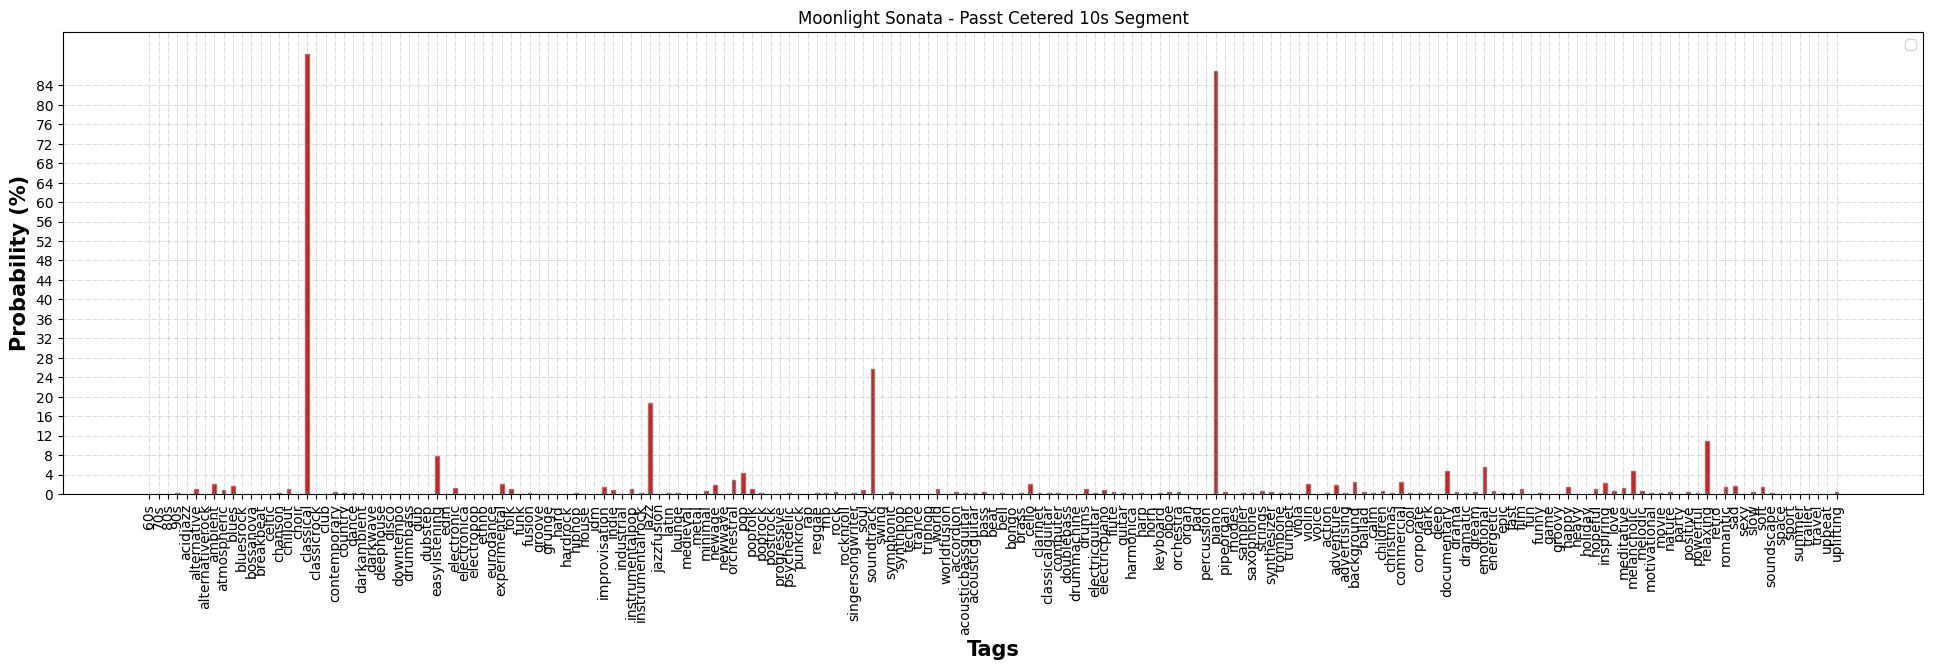

In [17]:
plot_model_out(model_out, 'Moonlight Sonata - Passt Cetered 10s Segment')

# Prison Song

In [6]:
prison_path = '/home/felipe/Desktop/prison_song.mp3'

prison_file = 'prison_song.mp3'
out_file = prison_file.split('.')[0]+'_%03d.wav'
out_file = os.path.join('/home/felipe/Desktop/prison', out_file)
print(out_file)

/home/felipe/Desktop/prision/prison_song_%03d.wav


### Central 29.1s window

In [7]:
# Convert to mono 32khz wav and split in 10s segments
stream = ffmpeg.input(prison_path)
stream = ffmpeg.output(stream, out_file, f='segment', segment_time=10, ar=32000, ac=1)
ffmpeg.run(stream)

ffmpeg version N-116327-gb3aeef3bf9 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.4.0-1ubuntu1~22.04)
  configuration: --enable-nonfree --enable-cuda-nvcc --enable-libnpp --extra-cflags=-I/usr/local/cuda/include --extra-ldflags=-L/usr/local/cuda/lib64 --disable-static --enable-shared
  libavutil      59. 28.100 / 59. 28.100
  libavcodec     61. 10.100 / 61. 10.100
  libavformat    61.  5.101 / 61.  5.101
  libavdevice    61.  2.100 / 61.  2.100
  libavfilter    10.  2.102 / 10.  2.102
  libswscale      8.  2.100 /  8.  2.100
  libswresample   5.  2.100 /  5.  2.100
Input #0, mp3, from '/home/felipe/Desktop/prison_song.mp3':
  Metadata:
    encoder         : Lavf58.29.100
  Duration: 00:03:24.74, start: 0.023021, bitrate: 128 kb/s
  Stream #0:0: Audio: mp3 (mp3float), 48000 Hz, stereo, fltp, 128 kb/s
      Metadata:
        encoder         : Lavc58.54
Stream mapping:
  Stream #0:0 -> #0:0 (mp3 (mp3float) -> pcm_s16le (native))
Press [q] to stop, [?] for he

(None, None)

In [8]:
prison_audio = torchaudio.load('/home/felipe/Desktop/prision/prison_song_010.wav')
prison_audio = prison_audio[0].squeeze()[:32000 * 10].cuda()
prison_audio.device

device(type='cuda', index=0)

In [9]:
model_out = model(prison_audio.unsqueeze(0))
model_out

/home/felipe/Documents/Github/Pt-Brdo/env/lib/python3.10/site-packages/torch/functional.py:650: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return format. (Triggered internally at ../aten/src/ATen/native/SpectralOps.cpp:863.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]
/home/felipe/Documents/Github/Pt-Brdo/env/lib/python3.10/site-packages/hear21passt/models/passt.py:304: UserWarning: Input image size (128*1000) doesn't match model (128*998).
  warnings.warn(f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]}).")


x torch.Size([1, 1, 128, 1000])
self.norm(x) torch.Size([1, 768, 12, 99])
 patch_embed :  torch.Size([1, 768, 12, 99])
 self.time_new_pos_embed.shape torch.Size([1, 768, 1, 99])
 self.freq_new_pos_embed.shape torch.Size([1, 768, 12, 1])
X flattened torch.Size([1, 1188, 768])
 self.new_pos_embed.shape torch.Size([1, 2, 768])
 self.cls_tokens.shape torch.Size([1, 1, 768])
 self.dist_token.shape torch.Size([1, 1, 768])
 final sequence x torch.Size([1, 1190, 768])
 after 12 atten blocks x torch.Size([1, 1190, 768])
forward_features torch.Size([1, 768])
head torch.Size([1, 183])


tensor([[1.2621e-06, 3.3079e-06, 4.8010e-05, 3.9177e-03, 1.2617e-05, 1.2896e-01,
         2.2973e-03, 3.9751e-03, 7.0039e-05, 1.7809e-03, 1.9229e-05, 1.8927e-04,
         1.2613e-04, 8.2476e-03, 2.2041e-06, 7.5287e-05, 1.5297e-05, 6.8936e-04,
         2.3680e-04, 5.0662e-05, 5.6833e-06, 6.4368e-05, 1.7532e-04, 1.0202e-05,
         2.0829e-04, 2.8137e-06, 2.4734e-04, 7.3205e-06, 9.3213e-05, 1.3242e-06,
         9.1910e-06, 1.1064e-03, 1.3293e-05, 5.4538e-04, 8.7225e-06, 2.6076e-05,
         1.5126e-04, 3.9116e-06, 1.7926e-03, 5.6024e-04, 5.2149e-02, 4.8225e-02,
         4.1469e-04, 2.8740e-03, 3.8473e-04, 5.3181e-03, 1.8383e-04, 2.8309e-05,
         3.3052e-05, 5.7884e-05, 2.0404e-03, 2.2500e-03, 7.0533e-05, 3.7664e-03,
         7.2907e-02, 1.4637e-04, 3.3628e-05, 1.2477e-04, 2.6925e-05, 3.8950e-01,
         6.8688e-06, 3.9794e-05, 2.0973e-04, 3.3548e-05, 8.2319e-03, 1.8925e-04,
         6.9586e-04, 5.3334e-04, 1.0176e-02, 9.9342e-05, 1.5205e-01, 4.2075e-04,
         6.5411e-04, 3.9540e

183


/tmp/ipykernel_359332/2492542175.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


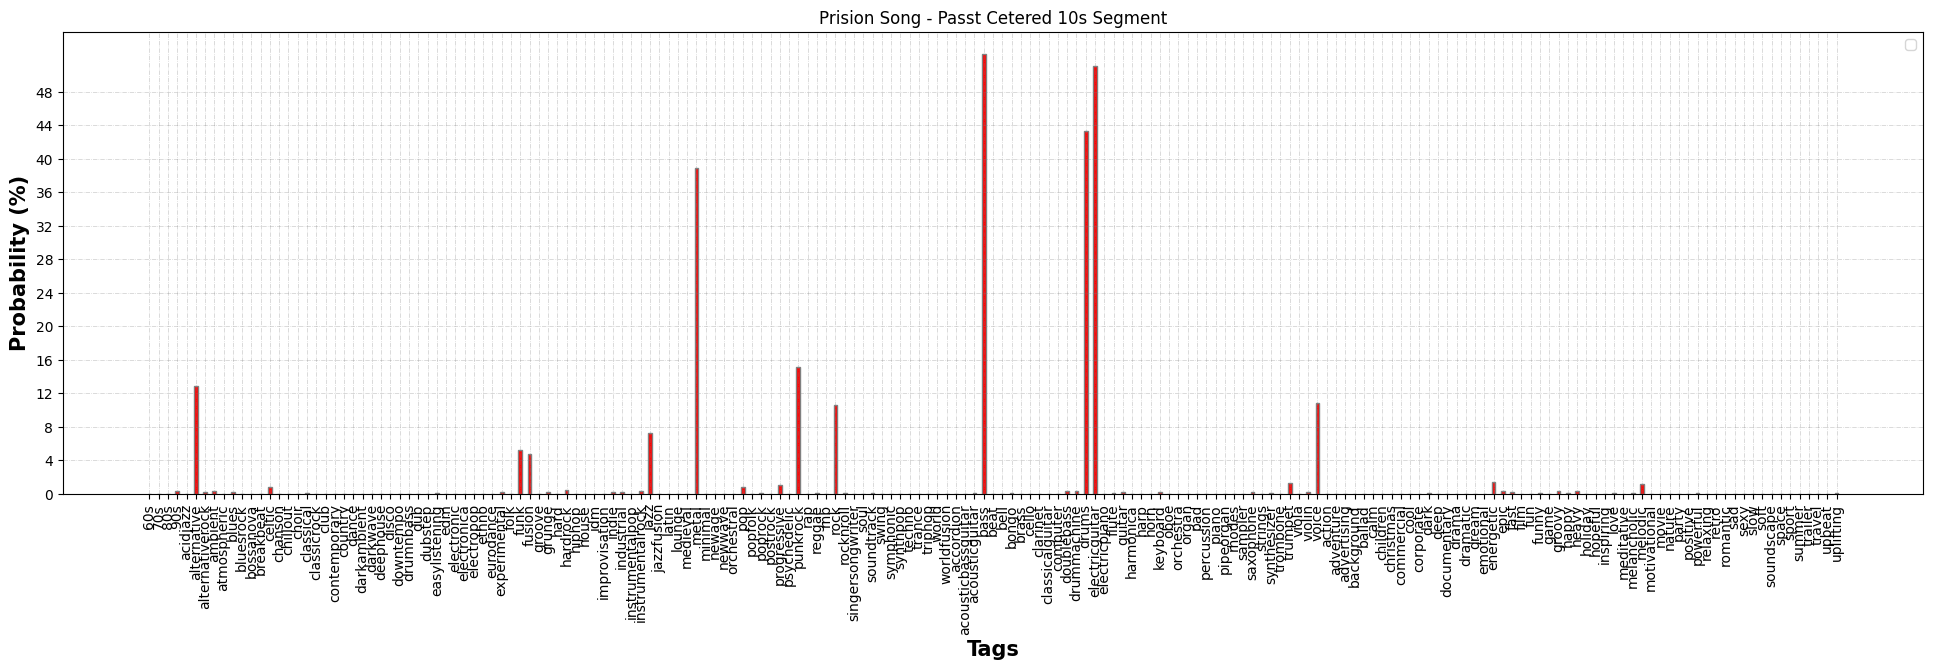

In [10]:
plot_model_out(model_out, 'Prison Song - Passt Cetered 10s Segment')

# 93 milion miles

In [11]:
milion_path = '/home/felipe/Desktop/93_million_miles.mp3'

milion_file = '93_million_miles.mp3'
out_file = milion_file.split('.')[0]+'_%03d.wav'
out_file = os.path.join('/home/felipe/Desktop/milion', out_file)
print(out_file)

/home/felipe/Desktop/milion/93_million_miles_%03d.wav


### Central 29.1s window

In [12]:
# Convert to mono 32khz wav and split in 10s segments
stream = ffmpeg.input(milion_path)
stream = ffmpeg.output(stream, out_file, f='segment', segment_time=10, ar=32000, ac=1)
ffmpeg.run(stream)

ffmpeg version N-116327-gb3aeef3bf9 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.4.0-1ubuntu1~22.04)
  configuration: --enable-nonfree --enable-cuda-nvcc --enable-libnpp --extra-cflags=-I/usr/local/cuda/include --extra-ldflags=-L/usr/local/cuda/lib64 --disable-static --enable-shared
  libavutil      59. 28.100 / 59. 28.100
  libavcodec     61. 10.100 / 61. 10.100
  libavformat    61.  5.101 / 61.  5.101
  libavdevice    61.  2.100 / 61.  2.100
  libavfilter    10.  2.102 / 10.  2.102
  libswscale      8.  2.100 /  8.  2.100
  libswresample   5.  2.100 /  5.  2.100
Input #0, mp3, from '/home/felipe/Desktop/93_million_miles.mp3':
  Metadata:
    major_brand     : mp42
    minor_version   : 0
    compatible_brands: isommp42
    encoder         : Lavf58.29.100
  Duration: 00:03:44.05, start: 0.025057, bitrate: 192 kb/s
  Stream #0:0: Audio: mp3 (mp3float), 44100 Hz, stereo, fltp, 192 kb/s
      Metadata:
        encoder         : Lavc58.54
Stream mapping:
  

(None, None)

In [13]:
milion_audio = torchaudio.load('/home/felipe/Desktop/milion/93_million_miles_010.wav')
milion_audio = milion_audio[0].squeeze()[:32000 * 10].cuda()
milion_audio.device

device(type='cuda', index=0)

In [14]:
model_out = model(milion_audio.unsqueeze(0))
model_out

/home/felipe/Documents/Github/Pt-Brdo/env/lib/python3.10/site-packages/torch/functional.py:650: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return format. (Triggered internally at ../aten/src/ATen/native/SpectralOps.cpp:863.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


x torch.Size([1, 1, 128, 998])
self.norm(x) torch.Size([1, 768, 12, 99])
 patch_embed :  torch.Size([1, 768, 12, 99])
 self.time_new_pos_embed.shape torch.Size([1, 768, 1, 99])
 self.freq_new_pos_embed.shape torch.Size([1, 768, 12, 1])
X flattened torch.Size([1, 1188, 768])
 self.new_pos_embed.shape torch.Size([1, 2, 768])
 self.cls_tokens.shape torch.Size([1, 1, 768])
 self.dist_token.shape torch.Size([1, 1, 768])
 final sequence x torch.Size([1, 1190, 768])
 after 12 atten blocks x torch.Size([1, 1190, 768])
forward_features torch.Size([1, 768])
head torch.Size([1, 183])


tensor([[4.6761e-04, 1.0942e-04, 2.7683e-04, 2.1022e-03, 5.3380e-04, 4.8123e-02,
         1.1560e-02, 3.0535e-02, 4.8383e-03, 2.6024e-03, 1.5566e-04, 3.5097e-04,
         5.2814e-04, 1.2617e-03, 1.2441e-04, 5.3767e-03, 1.9570e-05, 4.3241e-03,
         2.5480e-03, 6.3604e-05, 2.8274e-04, 1.3151e-01, 2.4301e-03, 2.5206e-04,
         1.5027e-04, 2.0564e-05, 7.6653e-04, 5.5643e-04, 6.8892e-05, 1.2961e-04,
         1.0639e-04, 2.3540e-02, 2.2688e-04, 2.6467e-02, 1.8087e-04, 2.6268e-02,
         7.8722e-04, 2.7506e-05, 5.9887e-03, 2.3067e-01, 5.6090e-03, 1.1726e-02,
         4.4560e-04, 3.5693e-03, 1.0537e-04, 3.9319e-03, 3.0859e-04, 1.2102e-03,
         8.5924e-06, 6.3218e-04, 6.1935e-02, 1.4986e-03, 1.4416e-03, 2.2507e-03,
         5.0460e-02, 1.8144e-03, 3.5591e-02, 5.6443e-03, 4.1480e-05, 6.5043e-03,
         9.0253e-05, 1.6792e-03, 1.3978e-04, 3.5937e-03, 5.7448e-01, 3.3888e-01,
         1.4538e-01, 5.2145e-04, 1.0561e-02, 3.0554e-03, 1.1503e-03, 1.1242e-04,
         2.8848e-04, 1.0465e

183


/tmp/ipykernel_350686/2492542175.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


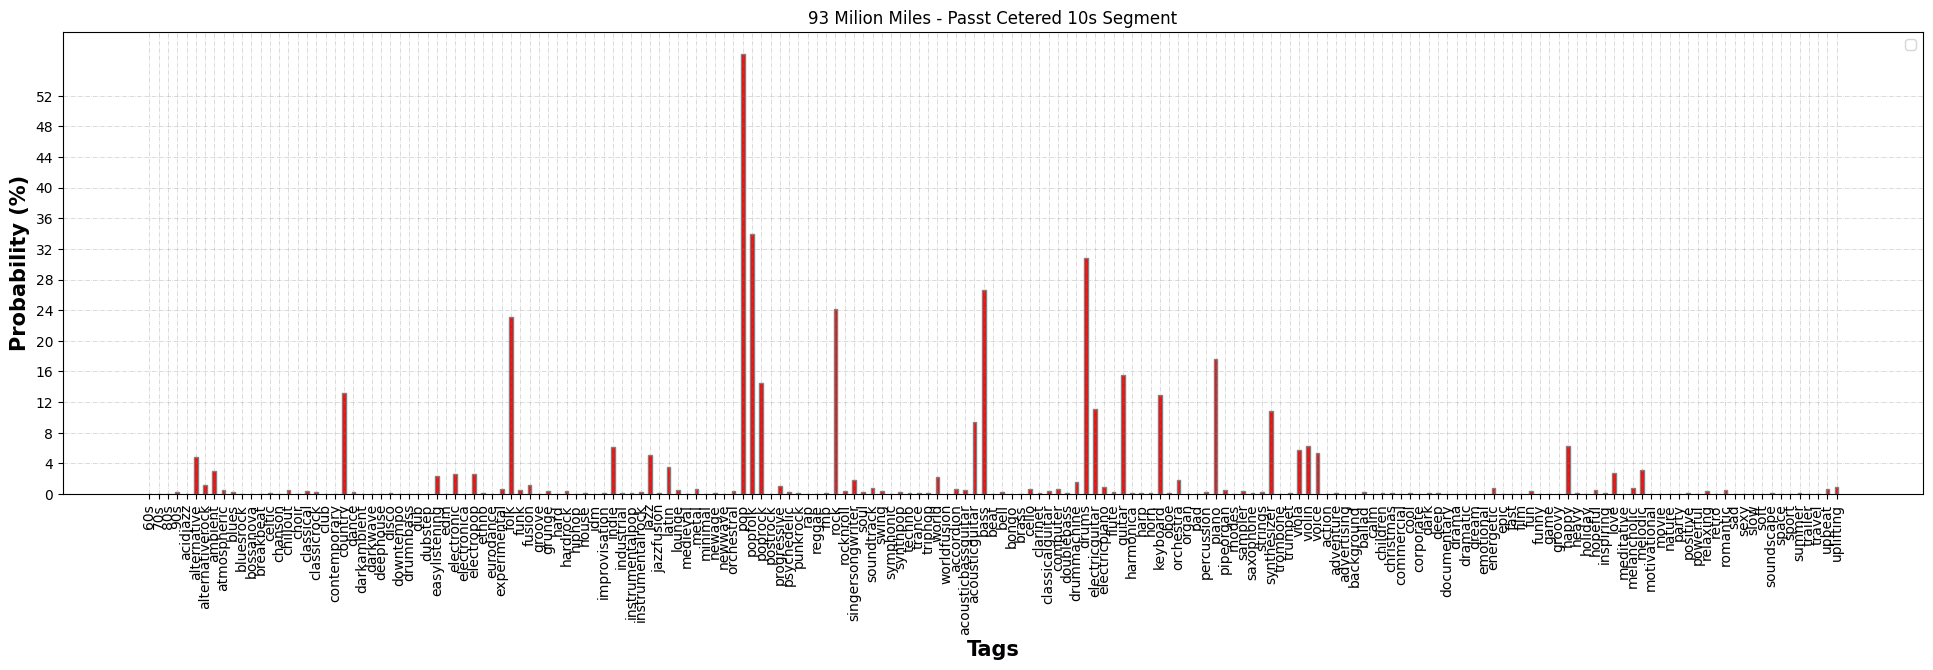

In [15]:
plot_model_out(model_out, '93 Milion Miles - Passt Cetered 10s Segment')